In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
(X_train, y_train), (X_test, y_test) = mnist.load_data()

from fc import FC
from getminibatch import GetMiniBatch
from initializer import SimpleInitializer,XavierInitializer,HeInitializer
from optimizer import SGD,AdaGrad
from activation import ReLU,Sigmoid,Softmax,Tanh
import warnings
warnings.simplefilter("ignore")

In [2]:
#全結合層のリストを引数に取ることで任意の構成のニューラルネットワークを作成するクラス
class ScratchDeepNeuralNetrowkClassifier:
    def __init__(self,lr=1e-5,batch_size=20,epoch=10,verbose=False):
        self.lr = lr
        self.batch_size = batch_size
        self.epoch = epoch
        self.verbose = verbose
        
    def fit(self,X_train,y_train,FC_list):
        X_train = X_train.reshape(X_train.shape[0],-1)
        self.n_features = X_train.shape[1]  #X_train.shape:(60000,748)
        self.L = np.empty(self.epoch)
        self.FC_list = FC_list
        
        #エポック数だけ繰り返す
        for epoch_num in range(self.epoch):
            get_mini_batch = GetMiniBatch(X_train, y_train,batch_size=self.batch_size)
            
            #ミニバッチ数だけ繰り返す
            for mini_X_train, mini_y_train in get_mini_batch:
                
                #フォワードプロパゲーション
                Z = self.FC_list[0].forward(mini_X_train)
                for i in range(1,len(self.FC_list)):
                    Z = self.FC_list[i].forward(Z)
                
                #ワンホットエンコーディング     
                y_train_one_hot = self.calc_one_hot(mini_y_train)
                
                #バックプロパゲーション
                dZ = self.FC_list[-1].backward(Z,y_train_one_hot[:self.batch_size,:])
                for i in reversed(range(len(self.FC_list)-1)):
                    dZ = self.FC_list[i].backward(dZ)

            #損失関数でself.loss_yを使うため、ここでpredictを呼び出す
            _ = self.predict(X_train)
            #ワンホットエンコーディング
            y_loss_one_hot = self.calc_one_hot(y_train)
            #損失関数を計算,表示
            self.L[epoch_num] = (-1/self.batch_size)*np.sum(y_loss_one_hot*np.log(self.loss_y+1e-7))
            if self.verbose:
                print("epoch{}: {}".format(epoch_num+1,self.L[epoch_num]))
            
    def predict(self,X):
        Z = X.reshape(X.shape[0],-1)
        for i in range(len(self.FC_list)):
            Z = self.FC_list[i].forward(Z)
            
        #self.loss_yは損失関数用のクラス変数
        self.loss_y = Z  
        pred = np.argmax(Z,axis=1)
        return pred
    
    def calc_one_hot(self,mini_y_train):
        for i in range(10):
            if i not in mini_y_train:
                mini_y_train = np.append(mini_y_train,i)
                
        #ワンホットエンコーディング
        enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
        y_train_one_hot = enc.fit_transform(mini_y_train[:, np.newaxis])
        return y_train_one_hot

In [3]:
#4層のニューラルネットワーク
lr = 1e-3
sigma = 0.01
FC_list = [FC(784, 400, ReLU(),HeInitializer(), AdaGrad(lr)),
           FC(400,200,Sigmoid(),XavierInitializer(),SGD(lr)),
           FC(200,100,Tanh(),XavierInitializer(),SGD(lr)),
           FC(100, 10, Softmax(),SimpleInitializer(sigma), SGD(lr))]

dnn = ScratchDeepNeuralNetrowkClassifier(lr=lr,epoch=8)
dnn.fit(X_train,y_train,FC_list)
pred = dnn.predict(X_test)

In [4]:
print(f"正解率：  {accuracy_score(y_test,pred)}")

正解率：  0.8663


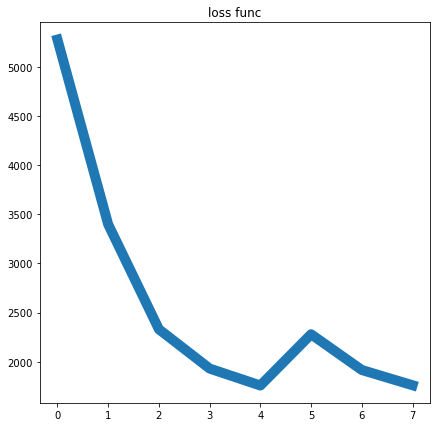

In [5]:
fig,ax = plt.subplots(1,1,figsize=(7,7))
ax.set_title("loss func")
ax.plot(dnn.L,linewidth=10)
plt.show()